### **Bioprospecting pipeline 1.0**

***
#### **Introduction**
***

The workflow presented here capitalizes on recent bioinformatic advances in BGC bioprospecting analysis to maximize the exploitation of metagenomic data. Briefly, our strategy consists of generating metagenome assemblies, including the reconstruction of metagenome assembled genomes (MAGs), identifying BGC sequences, clustering these sequences into Gene Cluster Families (GCFs), computing the BGC coverage and GCFs abundance, and performing the functional and taxonomic annotation.
Fig. 1 illustrates the implementation of this workflow.

![Figure 1](../figures/Bioprospectig_reads_vs_assembly_dev.png)

**Fig. 1**. Assembly-based bioprospecting pipeline. The input data consists of metagenomic samples previously preprocessed and assembled utilizing [VEBA](https://github.com/jolespin/veba). The pipeline is organized in five main tasks. **1) Identify BGC sequences:** the BGCs are annotated in the assembled metagenomic data utilizing [antiSMASH](https://github.com/antismash/antismash); **2) Taxonomic annotation:** the metagenomic contigs containing BGC sequences are taxonomically annotated utilizing [MMseqs taxonomy](https://github.com/soedinglab/MMseqs2#taxonomy) and the reference database [UniRef100](https://www.uniprot.org/help/uniref); **3) BGC mapping:** the metagenomic BGC sequences are mapped against (previously constructed) Gene Cluster Family (GCF) models of the MIBiG database v3 [MIBiG v3](https://mibig.secondarymetabolites.org/) utilizing [BiG-SLICE](https://github.com/pereiramemo/bigslice); **4) BGC clustering:** the metagenomic BGC sequences are clustered into GCFs with [BiG-SLICE](https://github.com/pereiramemo/bigslice); **5) Compute coverage:** the coverage of the metagenomic contigs, previously estimated with [VEBA](https://github.com/jolespin/veba), is utilized to determine the coverage of the BGC sequences. The output of the pipeline consists of the following tables: **Table 1:** functional and taxonomic annotation, biosynthetic novelty, and closest GCF id; **Table 2:** BGC class abundance table; **Table 3:** GCFs abundance table.

***
#### **Prepare the work environment**
***

In [2]:
%load_ext rpy2.ipython
%set_env WORKDIR=workdir
%set_env REPO=/home/epereira/workspace/dev/new_atlantis/repos/bioprospecting
%set_env seqtk=/nfs/bin/seqtk/seqtk

env: WORKDIR=workdir
env: REPO=/home/epereira/workspace/dev/new_atlantis/repos/bioprospecting
env: seqtk=/nfs/bin/seqtk/seqtk


In [7]:
%%bash

mkdir -p ${WORKDIR}/data/sola
mkdir -p ${WORKDIR}/outputs/antismash/taxonomy
mkdir ${WORKDIR}/outputs/bgc_abund
mkdir ${WORKDIR}/outputs/bgc_taxa
mkdir ${WORKDIR}/outputs/tables


ERROR: Error in parse(text = x, srcfile = src): <text>:1:1: unexpected SPECIAL
1: %%
    ^


***
#### **Input data**
***

The input data, as described in the figure above, are metagenomic samples previously preprocessed and assembled with VEBA. For the purpose of this notebook, we will analyze 38 metagenomes of the [SOLA dataset](https://pubmed.ncbi.nlm.nih.gov/29925880/). Namenly, the input consists of assembled contigs (fasta files) along with their mapping files (bam files).

Let's download the data.  

In [2]:
%%bash

aws s3 cp s3://newatlantis-case-studies/SOLA-samples/ ${WORKDIR}/data/sola --recursive

ERROR: Error in parse(text = x, srcfile = src): <text>:1:1: unexpected SPECIAL
1: %%
    ^


We will also download the previously constructed Gene Cluster Family (GCF) models of the MIBiG database, which we will need for the analysis below.

In [ ]:
%%bash
# aws s3 cp s3://newatlantis-case-studies/mibig_gcf_models/ ${WORKDIR}/data/mibig_gcf_models --recursive

***
#### **1) Identify BGC sequences**
***

For this we will be using our wrap script [run_antismash](https://github.com/pereiramemo/bioprospecting/blob/main/run_scripts/run_antismash.sh), which runs a our container of antiSMASH.  

In [ ]:
%%bash

SCAFFOLDS=$(ls ${WORKDIR}/data/sola/ERR*/output/scaffolds.fasta)
for SCAFFOLD in ${SCAFFOLDS}; do
  SAMPLE_NAME=$(echo "${SCAFFOLD}" | sed "s/.*\(ERR[0-9]\+\)\/output.*/\1/");
  OUTPUT_DIR="${WORKDIR}/outputs/antismash/${SAMPLE_NAME}";
  "${REPO}"/run_scripts/run_antismash.sh "${SCAFFOLD}" "${OUTPUT_DIR}" \
  --cpus 40 \
  --genefinding-tool prodigal-m \
  --taxon bacteria \
  --allow-long-headers \
  --minlength 5000;
done

***
#### **2) Taxonomic annotation of BGCs**
***

For this we will use our script [run_mmseqs_taxonomy.sh](https://github.com/pereiramemo/bioprospecting/blob/main/run_scripts/run_mmseqs_taxonomy.sh), which runs a container of [MMseqs](https://github.com/soedinglab/MMseqs2), utilizing [UniProtKB/Swiss-Prot](https://www.uniprot.org/uniprotkb?facets=reviewed%3Atrue&query=%2A) as the reference database.

Before doing anything, we have to organize the data and select the scaffolds in which a BGC was annotated:

In [8]:
%%bash
cat "${WORKDIR}"/outputs/bgc_abund/ERR*.tsv | cut -f1 | sort | uniq > "${WORKDIR}"/outputs/bgc_taxa/ids.txt

cat "${WORKDIR}"/data/sola/ERR*/output/scaffolds.fasta >  "${WORKDIR}"/outputs/bgc_taxa/all.fasta

"${seqtk}" subseq \

"${WORKDIR}"/outputs/bgc_taxa/all.fasta \

"${WORKDIR}"/outputs/bgc_taxa/ids.txt > \

"${WORKDIR}"/outputs/bgc_taxa/bgc.fasta

ERROR: Error in parse(text = x, srcfile = src): <text>:1:1: unexpected SPECIAL
1: %%
    ^


Now we can perform the taxonomic annotation.

In [ ]:
%%bash

"${REPO}"/run_scripts/run_mmseqs_taxonomy.sh \

"${WORKDIR}"/outputs/bgc_taxa/bgc.fasta \

"${WORKDIR}"/outputs/bgc_taxa/bgc_taxa_annot \

--threads 40 \

--tax-lineage 1 \

-v 0

Lastly, we will format the taxonomic datatable to make it more suitable for downstream analyses.

In [ ]:
%%bash

gawk -v FS="\t" -v OFS="\t" '{
  seq_id = $1; tax_level = $3; tax_path = $9;
  sample = gensub(/__.*/,"","g", seq_id);
  print sample,seq_id,tax_level,tax_path
  }' "${WORKDIR}"/outputs/bgc_taxa/bgc_taxa_annot_lca.tsv > \
  "${WORKDIR}"/outputs/bgc_taxa/bgc_taxa_annot_lca_formatted.tsv

***
#### **3) BGC mapping**
***

Here we will assess how similar are our BGC sequences found in the metagenomic samples in relation to known BGC sequences.  
For this analysis we will run the [BiG-SLICE](https://github.com/pereiramemo/bigslice) to map our BGCs against (previously constructed) GCF models of the [MIBiG database V3](https://mibig.secondarymetabolites.org/), downloaded above.

To be able to run [BiG-SLICE](https://github.com/pereiramemo/bigslice) we have to format the input properly, that is, creating the [dataset.tsv and taxonomy files](https://github.com/medema-group/bigslice/wiki/Input-folder). 

In [ ]:
%%bash

ls -d "${WORKDIR}/outputs/antismash/"ERR* | \
while read LINE; do
  DATASET=$(basename $(ls -d ${LINE}))
  PATH2DATASET=$(basename $(dirname ${LINE}))"/"
  echo -e "${DATASET}\t./\ttaxonomy/${DATASET}_taxonomy.tsv\tdataset_${DATASET}"
done > "${WORKDIR}/outputs/antismash/datasets.tsv"

ls "${WORKDIR}/outputs/antismash/"ERR*/scaffolds/ERR*region*.gbk | \
while read LINE; do
  DATASET=$(basename ${LINE/__k*.region*.gbk//})
  SEQID=$(basename ${LINE/.region*.gbk//})
  OUTPUT_FILE="${WORKDIR}/outputs/antismash/taxonomy/${DATASET}_taxonomy.tsv"
  echo -e "${SEQID}\tBacteria" >> "${OUTPUT_FILE}"
done

Now we do the mapping.

In [ ]:
%%bash

"${REPO}/run_scripts/run_bigslice.sh" query \
"${WORKDIR}/outputs/antismash/" \
"${WORKDIR}/data/mibig_gcf_models/" \
--num_threads 40 \
--threshold_pct 0.1 \
--query_name SOLA 

***
#### **4) BGC clustering**
***

Here again will use [BiG-SLICE](https://github.com/medema-group/bigslice), but this time to cluster our BGC sequences into Gene Cluster Families (GCFs).

In [ ]:
%%bash

"${REPO}/run_scripts/run_bigslice.sh" cluster \
"${WORKDIR}/outputs/antismash/" \
"${WORKDIR}/outputs/bgslice_clust/" \
--num_threads 40 \
--threshold_pct 0.1 1> /dev/null 2> /dev/null

***
#### **5) Compute coverage**
***

To do this, let's first concatenate all BGC gbk files from each metagenomic sample. 

In [67]:
%%bash

ls -d ${WORKDIR}/outputs/antismash/ERR* | \
while read LINE; do
  SAMPLE=$(basename "${LINE}")
  cat "${LINE}"/scaffolds/"${SAMPLE}"*.region*.gbk > "${WORKDIR}"/outputs/bgc_abund/"${SAMPLE}".gbk
done

Now we can run our custom scripts [get_cov.py](https://github.com/pereiramemo/bioprospecting/blob/main/aux_scripts/get_cov.py) to compute the coverage of each BGC.

In [72]:
%%bash

ls "${WORKDIR}"/outputs/bgc_abund/*.gbk | \
while read LINE; do
  SAMPLE=$(basename "${LINE}" .gbk)
  "${REPO}"/aux_scripts/get_cov.py \
  --input_gbk "${WORKDIR}"/outputs/bgc_abund/"${SAMPLE}".gbk \
  --input_bam "${WORKDIR}"/data/sola/"${SAMPLE}"/output/mapped.sorted.bam \
  --sample_name "${SAMPLE}" \
  --output_tsv "${WORKDIR}"/outputs/bgc_abund/"${SAMPLE}".tsv
done

cat "${WORKDIR}"/outputs/bgc_abund/ERR*.tsv  > "${WORKDIR}"/outputs/bgc_abund/bgc_abund.tsv

***
#### **Format outputs**
***

Lastly, after we run the five main tasks that comprise the bioprospecting pipeline, we format the output data generated to obtain the three tables described in Fig. 1.  

#### **Output table 1**.  
That is, the table containing the functional and taxonomic annotation, the biosynthetic novelty and GCF. 

In [85]:
%%R
library(RSQLite)
library(tidyverse)

TAX <- read_tsv("workdir/outputs/bgc_taxa/bgc_taxa_annot_lca_formatted.tsv", 
                col_names = F, show_col_types = F)
colnames(TAX) <- c("sample", "seq_id", "tax_level", "tax_path")
CONN_REPORTS_DB <- dbConnect(SQLite(), "workdir/data/mibig_gcf_models/reports/1/data.db")
CONN_DATA_DB <- dbConnect(SQLite(), "workdir/data/mibig_gcf_models/result/data.db")

REPORTS_LIST <- lapply(setNames(nm = dbListTables(CONN_REPORTS_DB)), dbReadTable, conn = CONN_REPORTS_DB)
DATA_LIST <- lapply(setNames(nm = dbListTables(CONN_DATA_DB)), dbReadTable, conn = CONN_DATA_DB)

REPORTS_LIST$bgc$seq_id <- sub(x = REPORTS_LIST$bgc$name, 
                               pattern = ".*/(.*).region[0-9]+$", 
                               replacement = "\\1")

metadata <- left_join(x = TAX, 
                      y = REPORTS_LIST$bgc,
                      by = "seq_id") %>%
            left_join(x = .,
                      y = REPORTS_LIST$gcf_membership, 
                      by = c("id" = "bgc_id")) %>%
            left_join(x = .,
                      y = REPORTS_LIST$bgc_class, 
                      by = c("id" = "bgc_id")) %>%
            left_join(x = .,
                      y = DATA_LIST$chem_subclass_map,
                      by = c("chem_subclass_id" = "subclass_id")) %>%
            select(seq_id, class_source, tax_path, membership_value, gcf_id)
        
colnames(metadata) <- c("seq_id", "function", "taxonomy", "novelty", "gcf_id")       
        
write.table(x = metadata, file = "workdir/outputs/tables/1-bgc_metadata.tsv", 
            sep = "\t", quote = F, row.names = F, col.names = T)

In [ ]:
pip install New_atlantis as NA

data = NA.bioprospecting_antismash(data)
viz = NA.bioprospecting_viz(data)

import subprocess as sub 

sub.run('bash commands

This is how it looks like:

In [86]:
%%bash

head "${WORKDIR}/outputs/tables/1-bgc_metadata.tsv"

seq_id	function	taxonomy	novelty	gcf_id
ERR2604090__k119_185408	terpene	-_cellular organisms;d_Bacteria;-_Terrabacteria group;-_Cyanobacteriota/Melainabacteria group;p_Cyanobacteriota;c_Cyanophyceae;o_Synechococcales	1.10505376873434	541
ERR2604090__k119_153928	arylpolyene	-_cellular organisms;d_Bacteria	0.952125515265246	1026
ERR2604090__k119_123795	terpene	-_cellular organisms;d_Bacteria;p_Pseudomonadota;c_Alphaproteobacteria;o_Rhodobacterales;f_Paracoccaceae	0.986966759230745	241
ERR2604090__k119_131898	redox-cofactor	-_cellular organisms;d_Bacteria;p_Pseudomonadota;c_Gammaproteobacteria	1.0320650538974	454
ERR2604090__k119_155472	redox-cofactor	-_cellular organisms;d_Bacteria;p_Pseudomonadota	1.12065717045078	454
ERR2604090__k119_52769	terpene	-_cellular organisms	1.26869265952904	391
ERR2604090__k119_148185	terpene	-_cellular organisms;d_Bacteria	1.14012573711592	391
ERR2604090__k119_84479	terpene	-_cellular organisms;d_Bacteria;p_Pseudomonadota	1.25337218528236	97
ERR2604090__k11

#### **Output table 2**  
That is, the BGC class abundance table.

In [111]:
%%R

BGC_ABUND <- read_tsv("workdir/outputs/bgc_abund/bgc_abund.tsv", 
                    col_names = F,
                    show_col_types = F)
colnames(BGC_ABUND) <- c("seq_id", "bgc_class", "edge", "start", "end", "abund", "sample")

BGC_ABUND_coll <- BGC_ABUND %>%
                  group_by(sample, bgc_class) %>%
                  summarize(abund = sum(abund))
    
write.table(x = BGC_ABUND_coll, file = "workdir/outputs/tables/2-bgc_abund.tsv", 
            sep = "\t", quote = F, row.names = F, col.names = T)

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.


This is how it looks like:

In [97]:
%%bash
head "${WORKDIR}/outputs/tables/2-bgc_abund.tsv"

sample	bgc_class	abund
ERR2604071	betalactone	1.01401006711409
ERR2604071	phosphonate	1.04183496826313
ERR2604071	resorcinol	1.01119288561791
ERR2604071	terpene	4.11969119492286
ERR2604073	betalactone	3.18565274708853
ERR2604073	hserlactone	1.06897456071335
ERR2604073	phosphonate	1.05259071729958
ERR2604073	redox-cofactor	1.07977006857604
ERR2604073	terpene	7.43873731742168


#### **Output table 3**
That is, the GCF abundance table.

In [108]:
%%R 
library(tidyverse)

BGC_METADATA <- read_tsv("workdir/outputs/tables/1-bgc_metadata.tsv", 
                         col_names = T, show_col_types = F)
BGC_ABUND <- read_tsv("workdir/outputs/bgc_abund/bgc_abund.tsv", 
                    col_names = F, show_col_types = F)
colnames(BGC_ABUND) <- c("seq_id", "bgc_class", "edge", "start", "end", "abund", "sample")

gcf_abund <- left_join(x = BGC_METADATA,
                       y = BGC_ABUND,
                       by = "seq_id") %>%
              group_by(sample, gcf_id) %>%
              summarize(abund = sum(abund))

write.table(x = gcf_abund, file = "workdir/outputs/tables/3-gcf_abund.tsv", 
            sep = "\t", quote = F, row.names = F, col.names = T)

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.


See the table:

In [109]:
%%bash
head "${WORKDIR}/outputs/tables/3-gcf_abund.tsv"

sample	gcf_id	abund
ERR2604071	16	1.04183496826313
ERR2604071	97	3.08552624974567
ERR2604071	369	1.03416494517718
ERR2604071	412	1.01119288561791
ERR2604071	527	1.01401006711409
ERR2604073	3	1.06926210955183
ERR2604073	16	3.12557237966895
ERR2604073	210	1.0821720326766
ERR2604073	334	1.09847298355521


Note: For convenience, we have created the [tidy](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) version of the tables 2 and 3 described in Fig. 1.

***
#### **Exploratory analysis**
***

Prepare the R environment.

In [ ]:
%%R
library(lubridate)
library(tidyverse)
library(vegan)
setwd("/home/epereira/workspace/dev/new_atlantis/repos/bioprospecting/")
source("aux_scripts/get_season_north.R")

bgc_colors <- c('#8c510a','#bf812d','#dfc27d','#f6e8c3',
                '#c7eae5','#80cdc1','#35978f','#01665e',
                '#abdda4','#66c2a5', '#d53e4f','#f46d43',
                '#fdae61','#40004b','#762a83', '#9970ab')
season_colors <- c("#154360", "#3c7810", "#c93f1b","#98482b")


Load the data tables.

In [4]:
%%R
METADATA_TBL <- read_csv("notebooks/workdir/data/SOLA_metadata_extended.tsv.gz",
                         col_names = T, show_col_types = F)
METADATA_TBL$Season <- factor(get_season_north(METADATA_TBL$collection_date), 
                             levels = c("Winter", "Spring", "Summer", "Fall"))
BGC_ABUND <- read_tsv("notebooks/workdir/outputs/tables/2-bgc_abund.tsv", 
                      col_names = T, show_col_types = F)

Let's visualize the BGC class composition.

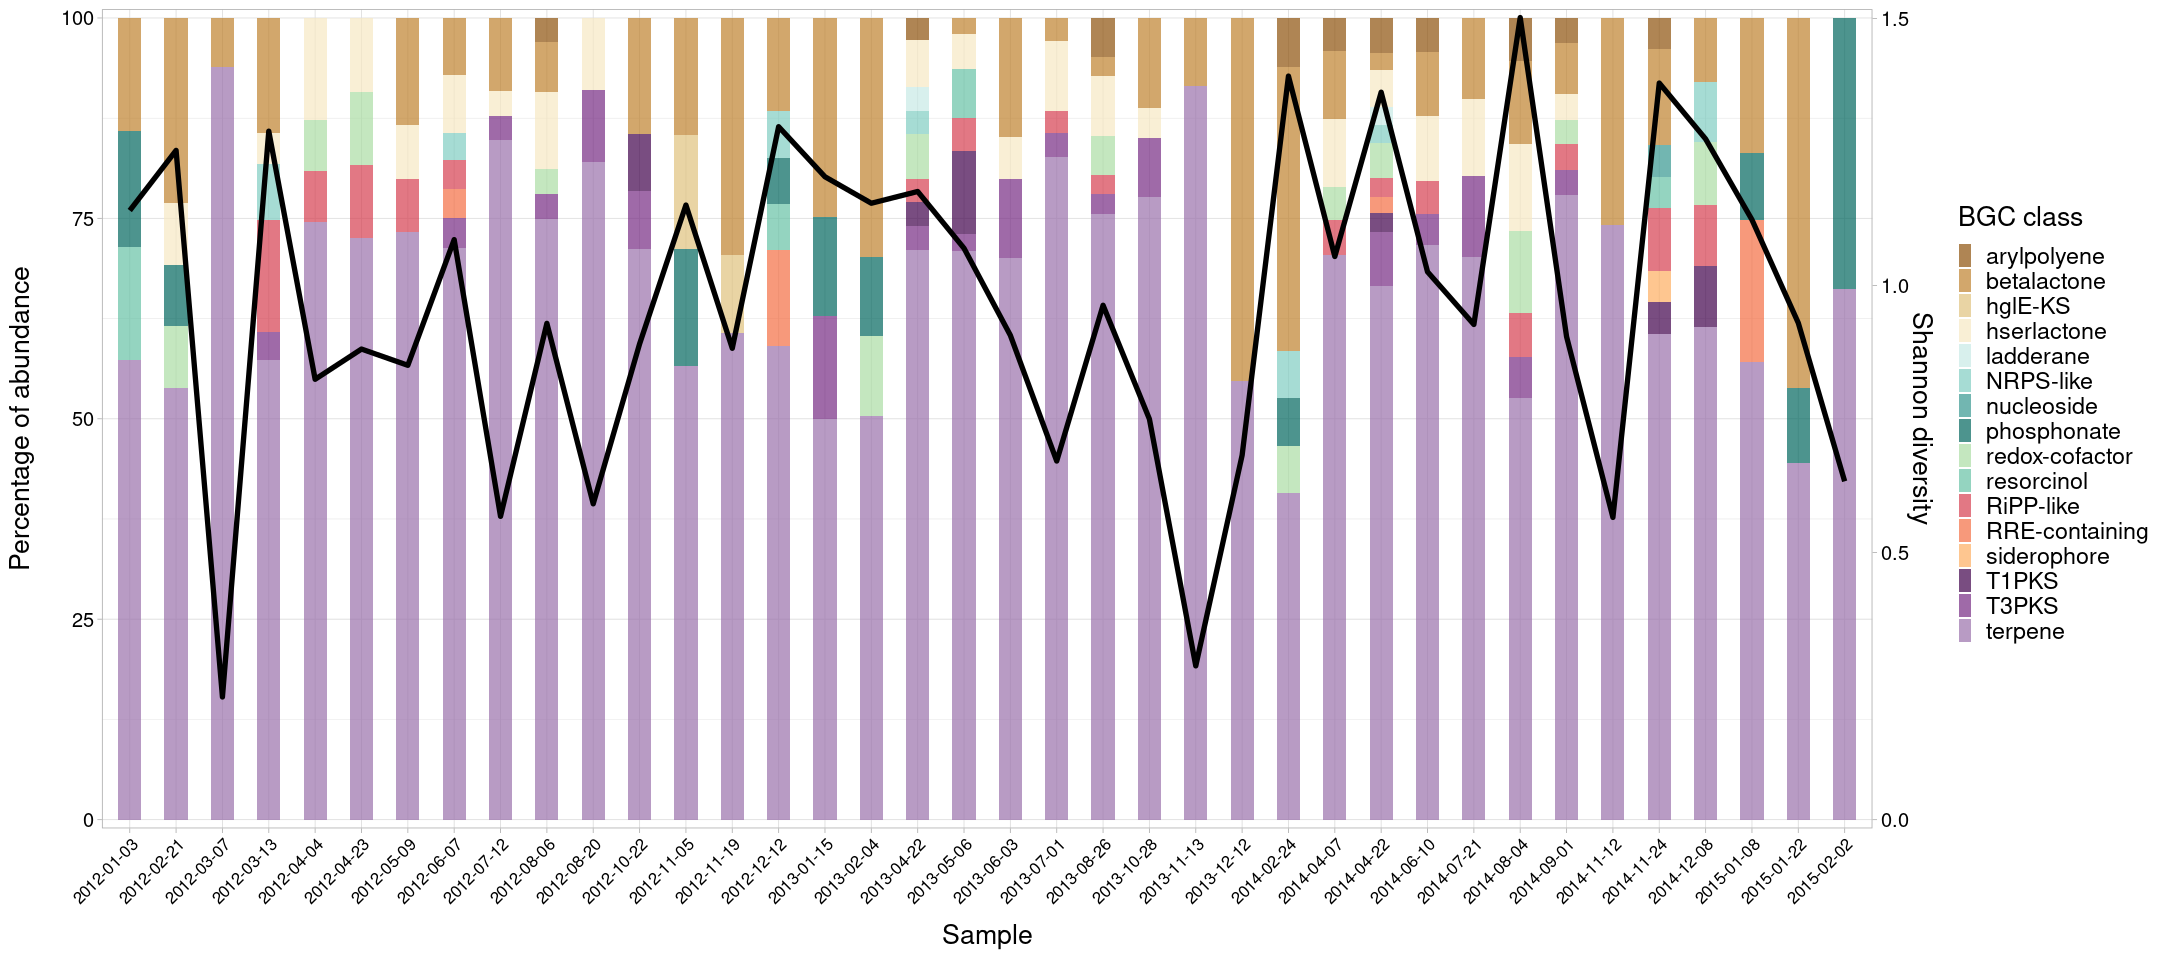

In [6]:
%%R
BGC_ABUND_ext <- left_join(x = BGC_ABUND, 
                           y = METADATA_TBL %>% select(run_accession, collection_date),
                           by = c("sample" = "run_accession")) %>%
                  group_by(sample) %>%
                  mutate(collection_date = as.character(collection_date),
                         abund_rel = 100*abund/sum(abund))
                  
      
bgc_class_names <- unique(BGC_ABUND_ext$bgc_class)
names(bgc_colors) <- bgc_class_names[order(bgc_class_names)]

text_size <- 12
BGC_ABUND_ext_div <- BGC_ABUND_ext %>%
                     group_by(collection_date) %>%
                     summarize(shannon = diversity(abund_rel))

barplot <- ggplot(BGC_ABUND_ext, aes(x = collection_date, y = abund_rel, fill = bgc_class)) + 
           geom_bar(stat = "identity", width = 0.5, alpha = 0.7) +
           xlab("Sample") +
           ylab("Percentage of abundance") +
           scale_fill_manual(name="BGC class",
                             values = bgc_colors) +
           scale_y_continuous(expand=c(0,0.1), limits = c(-1,101), 
                              sec.axis = sec_axis(~.*(max(BGC_ABUND_ext_div$shannon)/101), name = "Shannon diversity")) +
           theme_light() +
           theme( 
                 axis.text.x = element_text(size = text_size -2, angle = 45, 
                                            hjust = 1, color = "black"),
                 axis.text.y = element_text(size = text_size, color = "black"),
                 axis.title.x = element_text(size = text_size + 4, color = "black",
                                             margin = margin(10,0,0,0)),
                 axis.title.y = element_text(size = text_size + 4, color = "black",
                                             margin = margin(0,15,0,0)),
                 legend.text = element_text(size = text_size +2, color = "black"),
                 legend.title = element_text(size = text_size +4 , color = "black"),
                 legend.position = "right",
                 legend.margin = ggplot2::margin(0,0,-5,0),
                 strip.background = element_blank(),
                 strip.text = element_text(color = "black", size = text_size)) +
                 guides(fill = guide_legend(keywidth = 0.6, keyheight = 0.6)) +
          geom_line(data = BGC_ABUND_ext_div, aes(y = shannon*(99/1.5), fill = NULL, group = 1),
                     linewidth = 1.5) 

options(repr.plot.width=18, repr.plot.height=8)
barplot